#  Credit Card Transaction- PySpark ETL  
Author: Muhammad Helmy bin Roslan  
Environment: Python 3.10, PySpark 4.0.0  
---
# Description  
This notebook performs a full ETL and cleaning process on a semi-structured credit card fraud dataset using PySpark. It includes:  
- JSON flattening (multi-level)  
- PII handling  
- Timestamp conversion (to UTC+8)  
- Exploratory display of cleaned data


In [1]:
import os

# Set correct Java version path 
os.environ["JAVA_HOME"] = "C:\\Java\\jdk-17"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "\\bin;" + os.environ["PATH"]

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, split, to_timestamp, expr, concat_ws, lit, to_date, trim, when, length,size
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("CreditCardFraudETL") \
    .getOrCreate()


In [2]:
input_path = r"C:\Users\User\Documents\PayNet Assesment\cc_sample_transaction.json"

raw_df = spark.read.json(input_path)  # do NOT use .option("multiline", "true")

print("Total records loaded:", raw_df.count())
raw_df.printSchema()
raw_df.show(5, truncate=False)


Total records loaded: 1296675
root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)

+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+----------------------------------+-----------------------------------------------------------------------------------------------------------------------------------

In [3]:

# Address schema (nested JSON in personal_detail.address)
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

# Full personal_detail schema
personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True),   # <-- still a JSON string, so we parse it separately!
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

def flatten_personal_detail(df):
    return df \
        .withColumn("personal_struct", from_json(col("personal_detail"), personal_detail_schema)) \
        .withColumn("address_struct", from_json(col("personal_struct.address"), address_schema)) \
        .withColumn("name_split", split(col("personal_struct.person_name"), ",")) \
        .withColumn("first", trim(col("name_split").getItem(0))) \
        .withColumn(
            "last",
            when(size(col("name_split")) > 1, trim(col("name_split").getItem(1)))
            .otherwise(None)
        ) \
        .withColumn("gender", trim(col("personal_struct.gender"))) \
        .withColumn("street", col("address_struct.street")) \
        .withColumn("city", col("address_struct.city")) \
        .withColumn("state", col("address_struct.state")) \
        .withColumn("zip", col("address_struct.zip")) \
        .withColumn("lat", col("personal_struct.lat")) \
        .withColumn("long", col("personal_struct.long")) \
        .withColumn("city_pop", col("personal_struct.city_pop")) \
        .withColumn("job", col("personal_struct.job")) \
        .withColumn("dob", col("personal_struct.dob")) \
        .drop("name_split")


#### Data Cleaning Note: Name Splitting and Dropping Helper Columns

To safely extract first and last names from the `person_name` field, split the string using a comma as the separator. However, not all records have both first and last names.  
Use logic to avoid errors when a last name is missing, assigning `None` in such cases.  
After extracting the name components, drop the temporary `name_split` helper column to keep the DataFrame tidy.


In [4]:
flat_df = flatten_personal_detail(raw_df)
flat_df.select(
    "Unnamed: 0", "trans_date_trans_time", "cc_num", "merchant", "category", "amt",
    "first", "last", "gender", "street", "city", "state", "zip",
    "lat", "long", "city_pop", "job", "dob", "trans_num"
).show(5, truncate=False)
print(f"Total records: {flat_df.count()}")


+----------+---------------------+----------------+----------------------------------+-------------+------+--------------+-----+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first         |last |gender|street                      |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |
+----------+---------------------+----------------+----------------------------------+-------------+------+--------------+-----+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+
|0         |2019-01-01 00:00:18  |2703186189652095|fraud_Rippin, Kub and Mann        |misc_net     |4.97  |Je

In [5]:
def mask_pii(df):
    # Mask credit card number (show only last 4 digits)
    df = df.withColumn(
        "cc_num_masked",
        when(col("cc_num").isNotNull(),
             concat_ws("-", lit("XXXX"), lit("XXXX"), lit("XXXX"), col("cc_num").substr(-4, 4))
        ).otherwise(None)
    )
    # Mask date of birth
    df = df.withColumn("dob_masked", lit("REDACTED"))
    return df

# Apply function (make sure the input name is correct)
masked_df = mask_pii(flat_df)

# Show a preview
masked_df.select(
    "cc_num", "cc_num_masked", "dob", "dob_masked"
).show(5, truncate=False)


+----------------+-------------------+----------+----------+
|cc_num          |cc_num_masked      |dob       |dob_masked|
+----------------+-------------------+----------+----------+
|2703186189652095|XXXX-XXXX-XXXX-2095|1988-03-09|REDACTED  |
|630423337322    |XXXX-XXXX-XXXX-7322|1978-06-21|REDACTED  |
|38859492057661  |XXXX-XXXX-XXXX-7661|1962-01-19|REDACTED  |
|3534093764340240|XXXX-XXXX-XXXX-0240|1967-01-12|REDACTED  |
|375534208663984 |XXXX-XXXX-XXXX-3984|1986-03-28|REDACTED  |
+----------------+-------------------+----------+----------+
only showing top 5 rows


In [6]:
# Process timestamps and flag dirty rows
def process_timestamps_flag_dirty(df):
    df2 = df.withColumn(
        "trans_date_trans_time",
        to_timestamp("trans_date_trans_time", "yyyy-MM-dd HH:mm:ss")
    )
    for col_name in ["merch_last_update_time", "merch_eff_time"]:
        df2 = df2.withColumn(
            col_name,
            when(
                col(col_name).isNotNull() & (length(col(col_name)) >= 12) & (col(col_name).rlike("^[0-9]+$")),
                to_timestamp((col(col_name).cast("double")/1000))
            ).otherwise(None)
        )
    df2 = df2.withColumn(
        "dirty_row",
        when(
            col("trans_date_trans_time").isNull() |
            col("merch_last_update_time").isNull() |
            col("merch_eff_time").isNull(),
            lit(1)
        ).otherwise(lit(0))
    )
    return df2



In [7]:
# Apply timestamp processing and dirty flag
result_df = process_timestamps_flag_dirty(masked_df)

# Count & show dirty rows BEFORE dropping
dirty_count = result_df.filter("dirty_row = 1").count()
total_count = result_df.count()
print(f"Dirty rows before drop: {dirty_count} / {total_count} ({dirty_count/total_count:.2%})")

# OPTIONAL: show sample dirty rows for demo/report
result_df.filter("dirty_row = 1").select(
    "Unnamed: 0", "trans_date_trans_time", "merch_eff_time", "merch_last_update_time", "dirty_row"
).show(5, truncate=False)

# Now drop all dirty rows
final_df = result_df.filter("dirty_row = 0")
print(f"Final clean records: {final_df.count()}")


Dirty rows before drop: 12944 / 1296675 (1.00%)
+----------+---------------------+----------------------------+----------------------+---------+
|Unnamed: 0|trans_date_trans_time|merch_eff_time              |merch_last_update_time|dirty_row|
+----------+---------------------+----------------------------+----------------------+---------+
|188       |2019-01-01 02:20:56  |6169-12-23 02:54:36.162     |NULL                  |1        |
|291       |2019-01-01 03:49:40  |+43969-12-06 19:53:21.214208|NULL                  |1        |
|408       |2019-01-01 05:26:32  |+43970-02-12 02:20:42.128896|NULL                  |1        |
|451       |2019-01-01 05:56:54  |+43970-03-05 04:25:17.475072|NULL                  |1        |
|489       |2019-01-01 06:25:07  |+43970-03-24 18:50:07.76704 |NULL                  |1        |
+----------+---------------------+----------------------------+----------------------+---------+
only showing top 5 rows
Final clean records: 1283731


## Dirty Rows Handling
Since only about 1% of records have missing or bad timestamps, I dropped them for this assessment.
In real projects, it’s better to save or flag these rows into separate table instead of deleting them.

In [8]:
# Check for any rows with null or weird timestamps (again)
from pyspark.sql.functions import isnan

# Sanity check: Find impossible timestamps in any column
bad_merch_eff = final_df.filter(
    (col("merch_eff_time").isNull()) | (col("merch_last_update_time").isNull())
)
print("Bad merch timestamps after cleaning:", bad_merch_eff.count())

# Check min/max of epoch-based columns to see if any large or negative numbers slipped in
final_df.select("merch_eff_time", "merch_last_update_time").describe().show()


Bad merch timestamps after cleaning: 0
+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+



In [9]:
final_df_for_pandas = final_df.filter(
    col("trans_date_trans_time").isNotNull() &
    col("merch_eff_time").isNotNull() &
    col("merch_last_update_time").isNotNull()
).withColumn("trans_date_trans_time", col("trans_date_trans_time").cast("string")) \
 .withColumn("merch_eff_time", col("merch_eff_time").cast("string")) \
 .withColumn("merch_last_update_time", col("merch_last_update_time").cast("string"))

pdf = final_df_for_pandas.limit(5000).toPandas()


## Exploratory Data Analysis (EDA)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Basic EDA ---
total = len(pdf)
fraud = pdf['is_fraud'].astype(int).sum()
nonfraud = total - fraud

print("Total records:", total)
print("Fraud cases:", fraud)
print("Non-fraud cases:", nonfraud)
print("Unique merchants:", pdf['merchant'].nunique())
print("Unique categories:", pdf['category'].nunique())
print("Unique cities:", pdf['city'].nunique())


Total records: 5000
Fraud cases: 22
Non-fraud cases: 4978
Unique merchants: 692
Unique categories: 14
Unique cities: 812


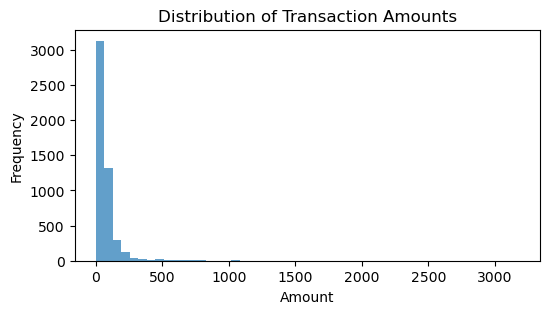

In [11]:
# --- 2. Amount Distribution ---
plt.figure(figsize=(6,3))
pdf['amt'] = pd.to_numeric(pdf['amt'], errors='coerce')
pdf['amt'].plot(kind='hist', bins=50, alpha=0.7)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

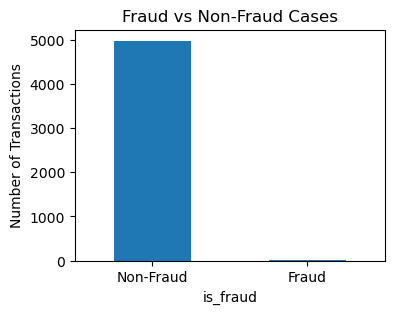

In [12]:
# --- 3. Fraud Bar Chart ---
plt.figure(figsize=(4,3))
pdf['is_fraud'].value_counts().sort_index().plot(kind='bar')
plt.title("Fraud vs Non-Fraud Cases")
plt.xlabel("is_fraud")
plt.ylabel("Number of Transactions")
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'], rotation=0)
plt.show()

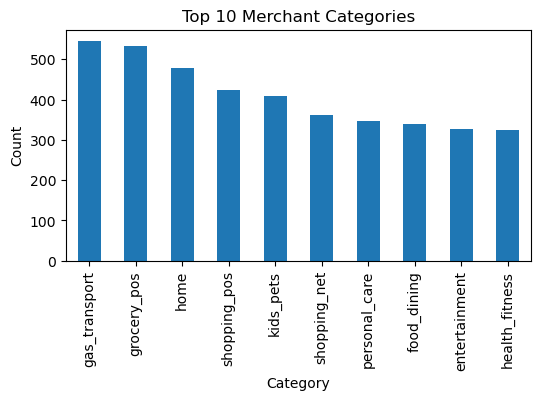

In [13]:
# --- 4. Top Categories ---
plt.figure(figsize=(6,3))
pdf['category'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Merchant Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

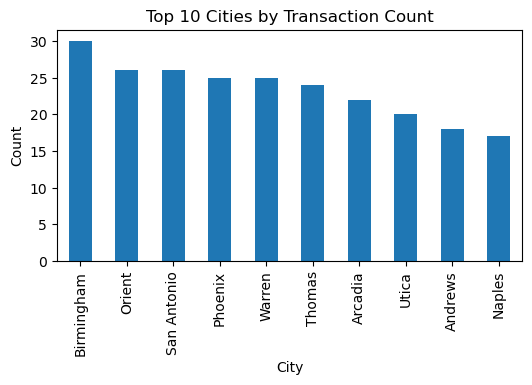

In [14]:
# --- 5. Top Cities (Optional) ---
plt.figure(figsize=(6,3))
pdf['city'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Cities by Transaction Count")
plt.xlabel("City")
plt.ylabel("Count")
plt.show()

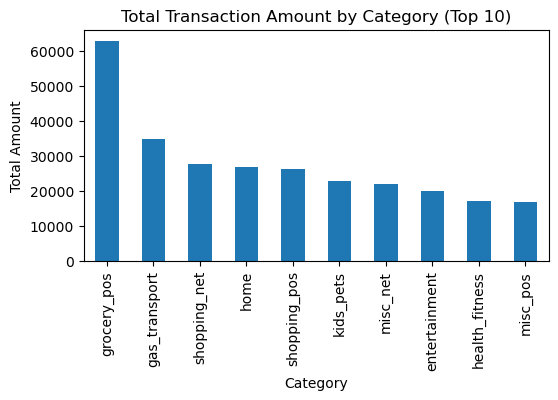

In [15]:
# --- 6. Total Amount by Category (Optional) ---
plt.figure(figsize=(6,3))
pdf.groupby('category')['amt'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title("Total Transaction Amount by Category (Top 10)")
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.show()

In [16]:
pdf.to_excel("credit_card_cleaned.xlsx", index=False)

## EDA Summary

Cleaned data was converted to Pandas for quick stats and charts.

Checked fraud rates and unique counts for merchants, categories, and cities.

This gives a basic overview of the dataset.

## Summary
Successfully performed end-to-end ETL and cleaning on a credit card transaction dataset using PySpark.

Flattened nested JSON, masked PII, handled timestamps, and dropped dirty rows (~1%).

Ran exploratory analysis and basic visualizations on the cleaned data.

In real-world projects, dirty records should be flagged, not dropped.